<a href="https://colab.research.google.com/github/sarmi2325/Supervised_Learning/blob/main/churn_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blastchar/telco-customer-churn")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/telco-customer-churn


In [61]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f"{path}/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [62]:
# Basic Cleanup
df = df.copy()
df = df.replace(" ", np.nan)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

In [63]:
# Encode binary categorical features
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df[col] = LabelEncoder().fit_transform(df[col])

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

In [64]:
# Tenure group
df['tenure_group'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], labels=['0-12','13-24','25-48','49-72'])

# Charges ratio
df['charges_ratio'] = df['MonthlyCharges'] / (df['TotalCharges'] + 1)

# Long contract indicator
df['is_long_contract'] = df['Contract'].apply(lambda x: 1 if 'Two year' in x else 0)

# Support services available
df['has_support_services'] = ((df['OnlineSecurity'] == 'Yes') | (df['TechSupport'] == 'Yes')).astype(int)

# Multiple services
df['is_multiple_services'] = ((df['InternetService'] != 'No') & (df['PhoneService'] == 1)).astype(int)

# Encode categorical columns (label or one-hot as preferred)
df = pd.get_dummies(df, columns=['Contract', 'PaymentMethod', 'InternetService', 'tenure_group'], drop_first=True)

In [67]:
non_numeric_cols = X_train.select_dtypes(include='object').columns
print(non_numeric_cols)



Index(['gender', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')


In [68]:
X = df.drop(['Churn', 'customerID'], axis=1)
X = pd.get_dummies(X, drop_first=True)

y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [69]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

In [71]:
# Base model
rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Calibrated model (5-fold CV)
calibrated_rf = CalibratedClassifierCV(estimator=rf, method='isotonic', cv=5)
calibrated_rf.fit(X_train_sm, y_train_sm)

CalibratedClassifierCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                       method='isotonic')

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.85      1549
           1       0.60      0.53      0.56       561

    accuracy                           0.78      2110
   macro avg       0.72      0.70      0.71      2110
weighted avg       0.77      0.78      0.78      2110



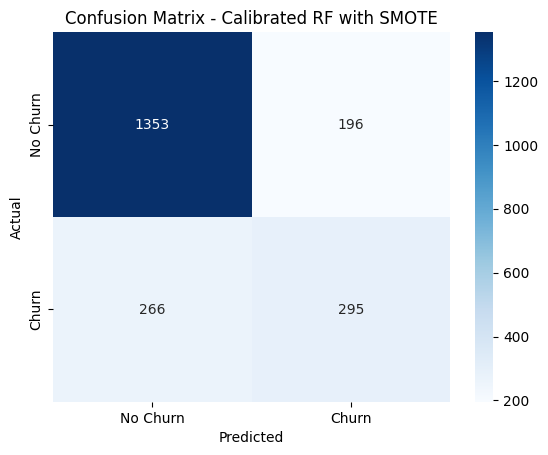

AUC Score: 0.8144683074239145


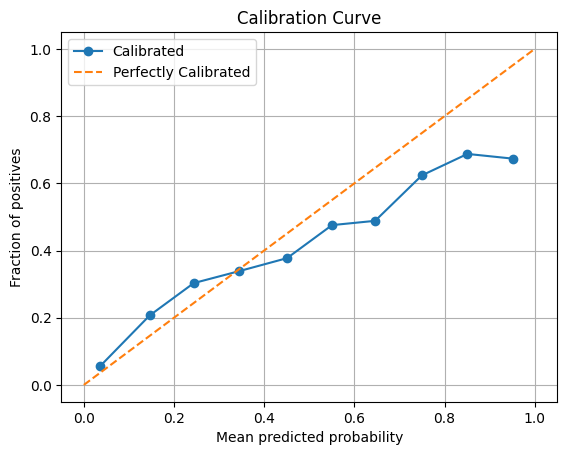

In [72]:
# Predict calibrated probabilities & labels
y_prob = calibrated_rf.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Calibrated RF with SMOTE")
plt.show()

# AUC Score
print("AUC Score:", roc_auc_score(y_test, y_prob))

# Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o', label='Calibrated')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid()
plt.show()